In [12]:
pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud streamlit


In [13]:
import zipfile
import os

zip_path = "/content/amazon data set.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/amazon_data")

print("Files extracted:")
os.listdir("/content/amazon_data")


Files extracted:


['Reviews.csv']

In [14]:
import pandas as pd

df = pd.read_csv("/content/amazon_data/Reviews.csv")
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [15]:
def get_sentiment(score):
    if score >= 4:
        return "Positive"
    elif score == 3:
        return "Neutral"
    else:
        return "Negative"

df["sentiment"] = df["Score"].apply(get_sentiment)
df[["Score", "sentiment"]].head()


,Score,sentiment
0,5,Positive
1,1,Negative
2,4,Positive
3,2,Negative
4,5,Positive


In [16]:
df = df[["Text", "sentiment"]]
df.head()


,Text,sentiment
0,I have bought several of the Vitality canned d...,Positive
1,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,This is a confection that has been around a fe...,Positive
3,If you are looking for the secret ingredient i...,Negative
4,Great taffy at a great price. There was a wid...,Positive


In [17]:
df["sentiment"].value_counts()


,count
sentiment,
Positive,443777
Negative,82037
Neutral,42640


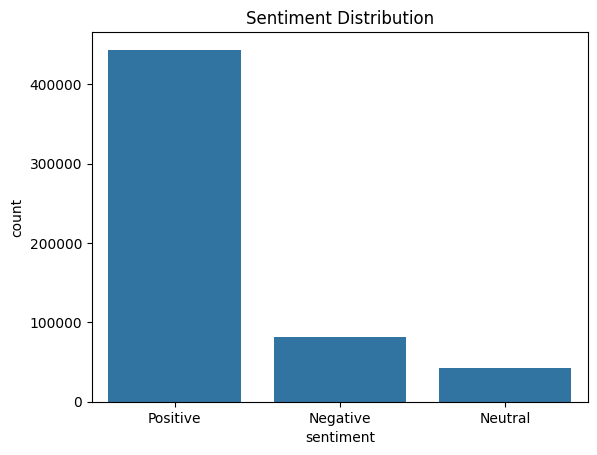

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Distribution")
plt.show()


In [19]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df["clean_text"] = df["Text"].apply(clean_text)
df.head()


,Text,sentiment,clean_text
0,I have bought several of the Vitality canned d...,Positive,bought several vitality canned dog food produc...
1,Product arrived labeled as Jumbo Salted Peanut...,Negative,product arrived labeled jumbo salted peanutsth...
2,This is a confection that has been around a fe...,Positive,confection around century light pillowy citrus...
3,If you are looking for the secret ingredient i...,Negative,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,Positive,great taffy great price wide assortment yummy ...


In [21]:
df.head()
df.isnull().sum()


,0
Text,0
sentiment,0
clean_text,0


In [22]:
X = df["clean_text"]
y = df["sentiment"]


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(X)


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [25]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


MultinomialNB()

In [26]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [27]:
from sklearn.metrics import accuracy_score, classification_report

nb_pred = nb_model.predict(X_test)
lr_pred = lr_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))


Naive Bayes Accuracy: 0.8235480381032799
Logistic Regression Accuracy: 0.8697346315891319


In [28]:
print("Logistic Regression Report:")
print(classification_report(y_test, lr_pred))


Logistic Regression Report:
              precision    recall  f1-score   support

    Negative       0.74      0.68      0.71     16407
     Neutral       0.53      0.21      0.30      8528
    Positive       0.90      0.97      0.93     88756

    accuracy                           0.87    113691
   macro avg       0.73      0.62      0.65    113691
weighted avg       0.85      0.87      0.85    113691



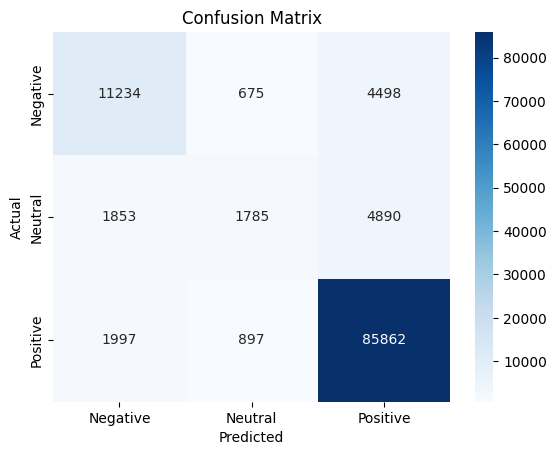

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [30]:
def predict_sentiment(review):
    clean = clean_text(review)
    vec = tfidf.transform([clean])
    return lr_model.predict(vec)[0]

predict_sentiment("This product is amazing and worth the price")
predict_sentiment("Worst quality, totally disappointed")


'Negative'

In [31]:
import pickle

pickle.dump(lr_model, open("sentiment_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf_vectorizer.pkl", "wb"))


In [32]:
import streamlit as st
import pickle

model = pickle.load(open("sentiment_model.pkl","rb"))
vectorizer = pickle.load(open("tfidf_vectorizer.pkl","rb"))

st.title("Amazon Review Sentiment Analysis")

review = st.text_area("Enter your review")

if st.button("Predict"):
    cleaned = clean_text(review)
    vect = vectorizer.transform([cleaned])
    result = model.predict(vect)[0]
    st.success(f"Sentiment: {result}")


2026-01-09 15:35:28.594 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-09 15:35:28.965 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-01-09 15:35:28.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-09 15:35:28.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-09 15:35:28.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-09 15:35:28.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-09 15:35:28.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-09 15:35:28.971 Thread 'MainThread': mi

In [34]:
%%writefile app.py
import streamlit as st
import pickle
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

model = pickle.load(open("sentiment_model.pkl","rb"))
vectorizer = pickle.load(open("tfidf_vectorizer.pkl","rb"))

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

st.title("Amazon Review Sentiment Analysis")

review = st.text_area("Enter your review")

if st.button("Predict"):
    cleaned = clean_text(review)
    vect = vectorizer.transform([cleaned])
    result = model.predict(vect)[0]
    st.success(f"Sentiment: {result}")


Writing app.py


In [ ]:
!streamlit run app.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.125.200:8501

